# Measures a vector sum with different accumulator type

This notebook compares how fast is the sum if the accumulator used to store the sum is of a different type than the summed elements.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

[numpy](http://www.numpy.org/) is multithreaded. For an accurate comparison, this needs to be disabled. This can be done as follows or by setting environment variable ``MKL_NUM_THREADS=1``.

In [3]:
try:
    import mkl
    mkl.set_num_threads(1)
except ModuleNotFoundError as e:
    print('mkl not found', e)
    import os
    os.environ['MKL_NUM_THREADS']='1'

## First comparison

We compare the two following implementation.

In [4]:
# float scenario_Float(const float *p1, size_t size)
# {
#     float sum = 0;
#     const float * end1 = p1 + size;
#     for(; p1 != end1; ++p1)
#         sum += *p1;
#     return sum;
# }
# 
# float scenario_Double(const float *p1, size_t size)
# {
#     double sum = 0;
#     const float * end1 = p1 + size;
#     for(; p1 != end1; ++p1)
#         sum += *p1;
#     return (float)sum;
# }

The third line is also repeated 10 times to avoid the loop being too significant. 

In [5]:
from cpyquickhelper.numbers.cbenchmark_sum_type import measure_scenario_Double, measure_scenario_Float

In [6]:
import pandas
import numpy

def test_benchmark(label, values, repeat=100, number=100):
    funcs = [(k, v) for k, v in globals().copy().items() if k.startswith("measure_scenario")]
    rows = []
    for k, v in funcs:
        exe = v(values, repeat, number)
        d = exe.todict()
        d['doc'] = " ".join(v.__doc__.split('ExecutionStat')[1].strip().split(' ')[-3:]).strip('.')
        d['label'] = label
        d['name'] = k.replace("measure_", "")
        rows.append(d)        
    df = pandas.DataFrame(rows)
    return df

test_benchmark("sorted", numpy.random.rand(10).astype(numpy.float32))

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,7.664200e-09,7.683250e-08,a double accumulator,sorted,7.910000e-07,3.950000e-07,scenario_Double,100.0,100.0
1,5.096300e-09,5.378331e-08,a float accumulator,sorted,7.910000e-07,3.950000e-07,scenario_Float,100.0,100.0


Times are not very conclusive on such small lists.

In [7]:
values = numpy.random.rand(100000).astype(numpy.float32)

df = test_benchmark("sorted", values)
df

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat
0,0.000140,0.00143,a double accumulator,sorted,0.042079,0.013098,scenario_Double,100.0,100.0
1,0.000141,0.00143,a float accumulator,sorted,0.037468,0.013094,scenario_Float,100.0,100.0


In [8]:
df = pandas.concat([df])
dfg = df[["doc", "label", "average"]].pivot("doc", "label", "average")

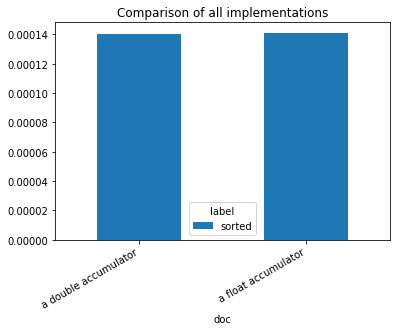

In [9]:
ax = dfg.plot.bar(rot=30)
labels = [l.get_text() for l in ax.get_xticklabels()]
ax.set_xticklabels(labels, ha='right')
ax.set_title("Comparison of all implementations");

## For different sizes

In [10]:
dfs = []

for i in range(2, 7):
    n = 10 ** i
    values = numpy.random.rand(n).astype(numpy.float32)
    df = test_benchmark("sorted", values, repeat=20)
    df["size"] = float(n)
    dfs.append(df)
    
df = pandas.concat(dfs)
df.head()

,average,deviation,doc,label,max_exec,min_exec,name,number,repeat,size
0,1.418275e-07,0.000001,a double accumulator,sorted,0.000026,0.000013,scenario_Double,100.0,20.0,100.0
1,1.590125e-07,0.000002,a float accumulator,sorted,0.000043,0.000012,scenario_Float,100.0,20.0,100.0
0,1.380739e-06,0.000014,a double accumulator,sorted,0.000190,0.000127,scenario_Double,100.0,20.0,1000.0
1,1.292245e-06,0.000013,a float accumulator,sorted,0.000161,0.000124,scenario_Float,100.0,20.0,1000.0
0,1.415682e-05,0.000142,a double accumulator,sorted,0.001969,0.001293,scenario_Double,100.0,20.0,10000.0


In [11]:
piv = df.pivot("size", "doc", "average")
cols = piv.columns
piv = piv.reset_index(drop=False)
piv["ratio"] = piv["a double accumulator"] / piv["a float accumulator"]
piv

doc,size,a double accumulator,a float accumulator,ratio
0,100.0,1.418275e-07,1.590125e-07,0.891927
1,1000.0,1.380739e-06,1.292245e-06,1.068480
2,10000.0,1.415682e-05,1.347988e-05,1.050218
3,100000.0,1.558953e-04,1.326750e-04,1.175017
4,1000000.0,1.391328e-03,1.367595e-03,1.017354


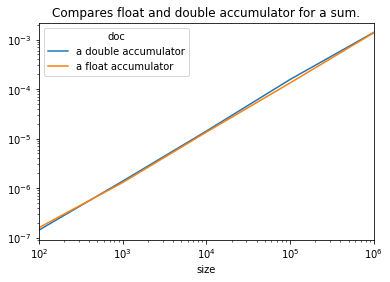

In [12]:
ax = piv.plot(x='size', y=cols, logy=True, logx=True)
ax.set_title("Compares float and double accumulator for a sum.");

There is almost no difference.